<a href="https://colab.research.google.com/github/brunoalexco/ds-ml-classification-room-occupancy/blob/main/room_occupancy_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from scipy.stats import randint
from scipy.stats import uniform

from sklearn.metrics import accuracy_score, classification_report, auc, roc_curve,ConfusionMatrixDisplay

In [2]:
df_ocu = pd.read_csv('https://raw.githubusercontent.com/brunoalexco/ds-ml-classification-room-occupancy/main/occupancy.csv')
df_ocu.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [3]:
df_ocu.tail()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
8138,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8139,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8140,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8141,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1
8142,2015-02-10 09:33:00,21.10,36.2000,447.0,821.000000,0.005612,1


The time slots are 60 seconds long over around 5 days. I suspect a correlation between the day/time and the use of these rooms.

# EXPLORATORY DATA ANALYSIS

In [4]:
df_ocu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 445.4+ KB


In [5]:
df_ocu.duplicated().sum()

0

In [6]:
df_ocu.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


As it was analyzed at the beginning, we will proceed to split the data column: day and hour.

In [7]:
df_ocu['date'] = pd.to_datetime(df_ocu['date'])

In [8]:
df_ocu['day'] = df_ocu['date'].dt.day
df_ocu['hour'] = df_ocu['date'].dt.hour

df_ocu.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,4,17
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,4,17
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,4,17
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,4,17
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,4,17


In [9]:
df_ocu['day'].value_counts()

5     1440
6     1440
7     1440
8     1440
9     1440
10     574
4      369
Name: day, dtype: int64

The date range includes 2015-02-04 (Wednesday) - 2015-02-10 (Tuesday). What I need for the model is the number of the day in the week and not the date, for that I will use the method dt.day_of_week()



In [10]:
df_ocu['day'] = df_ocu['date'].dt.day_of_week
df_ocu

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1,2,17
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1,2,17
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1,2,17
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1,2,17
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1,2,17
...,...,...,...,...,...,...,...,...,...
8138,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1,1,9
8139,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1,1,9
8140,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1,1,9
8141,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1,1,9


In [11]:
df_ocu['Occupancy'].value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

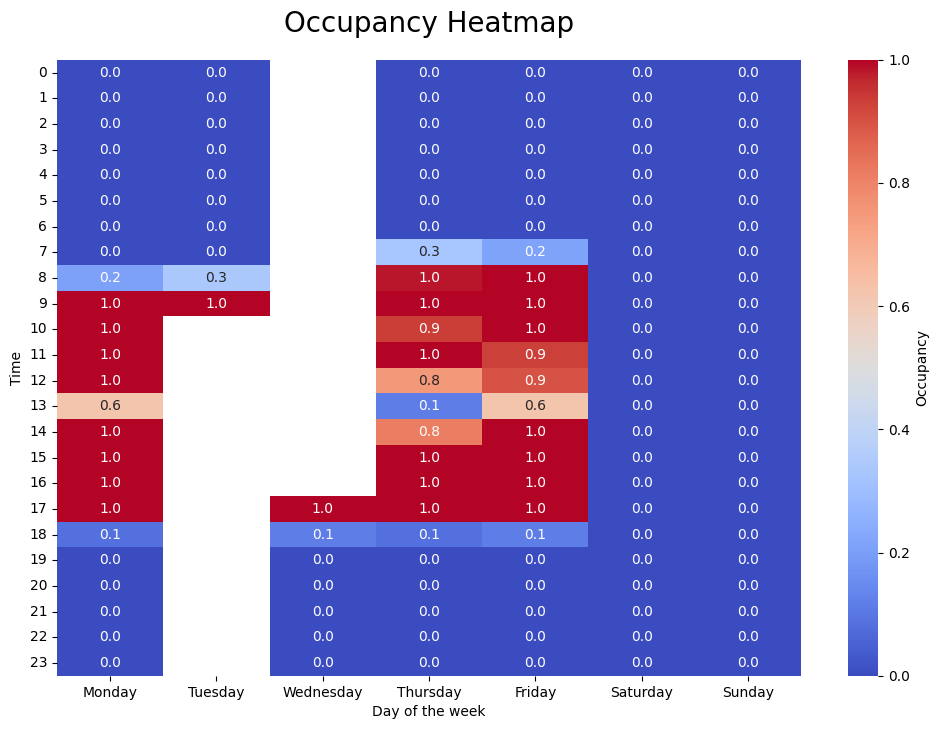

In [12]:
pivot = df_ocu.pivot_table(index='hour', columns='day', values='Occupancy', aggfunc='mean')

weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(pivot, cmap='coolwarm', annot=True, fmt=".1f", cbar_kws={'label': 'Occupancy'})

heatmap.set_xticks(range(len(weekday)))
heatmap.set_xticklabels(weekday)

heatmap.set_xticks([i + 0.5 for i in range(len(weekday))])
heatmap.set_xticklabels(weekday, ha='center')

heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.xlabel('Day of the week')
plt.ylabel('Time')
plt.title('Occupancy Heatmap', size = 20, pad=20)

plt.show()

<ipython-input-13-15814bc10c6c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_ocu.corr()


<Axes: >

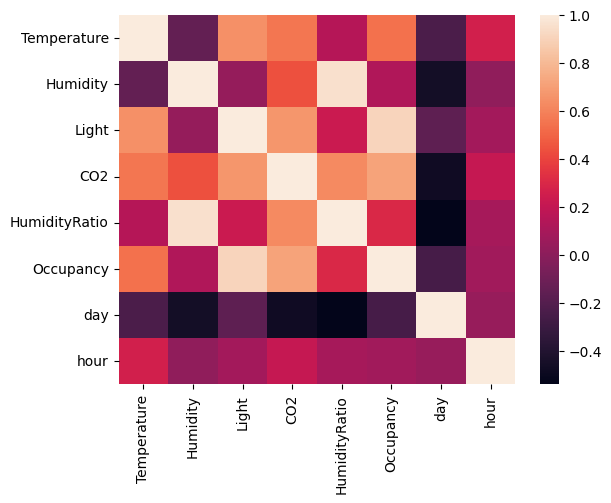

In [13]:
corr = df_ocu.corr()

sns.heatmap(corr)

## Notes


1. The first graph clearly shows the correlation between the day and hour of the week and the occupancy status of the office. To use resources efficiently, I could use only the day and hour columns to determine the office's availability.

2. For the other variables, it is not very clear if the other variables are correlated or not. Light and CO2 are good indicators, while temperature and humidity may have a non-linear effect.

3. I will remove the date column since it is redundant.

4. As for the class imbalance in the target column, I think it reflects the reality and resampling will not add any extra information to the model.

In [14]:
df_ocu.drop('date', axis=1, inplace=True)

In [15]:
df_ocu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    8143 non-null   float64
 1   Humidity       8143 non-null   float64
 2   Light          8143 non-null   float64
 3   CO2            8143 non-null   float64
 4   HumidityRatio  8143 non-null   float64
 5   Occupancy      8143 non-null   int64  
 6   day            8143 non-null   int64  
 7   hour           8143 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 509.1 KB


# PREPROCESSING

In [16]:
X = df_ocu.drop(columns='Occupancy')
y = df_ocu['Occupancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y,random_state=42)
X_train

,Temperature,Humidity,Light,CO2,HumidityRatio,day,hour
7146,22.100000,38.872500,433.0,1997.500000,0.006415,0,16
5694,19.525000,26.945000,24.0,422.000000,0.003779,6,16
3102,20.200000,18.890000,0.0,443.000000,0.002758,4,21
1086,22.175000,27.125000,460.0,1136.000000,0.004483,3,11
6023,19.500000,27.600000,0.0,451.000000,0.003865,6,22
...,...,...,...,...,...,...,...
2958,20.790000,19.600000,0.0,551.666667,0.002969,4,19
7297,20.790000,35.730000,0.0,1145.666667,0.005433,0,19
4350,20.290000,22.500000,0.0,432.000000,0.003306,5,18
5269,19.426667,30.533333,37.0,426.666667,0.004259,6,9


We will only select the floats, we will not standardize the Hour or Day columns.

In [17]:
flt_sel = make_column_selector(dtype_include='float')
cat_sel = make_column_selector(dtype_include='object')

imputer_float = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = make_column_transformer((make_pipeline(imputer_float, scaler),flt_sel),
                                      (make_pipeline(imputer_cat, ohe), cat_sel),
                                      remainder='passthrough')

pipe = make_pipeline(preprocessor)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7b41db2ce020>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7b41db2cca30>)]))])

In [18]:
pipe.fit(X_train)

X_train_processed = pipe.transform(X_train)
X_test_processed = pipe.transform(X_test)

X_train_processed = pd.DataFrame(X_train_processed, columns = X_train.columns)
X_test_processed = pd.DataFrame(X_test_processed, columns = X_train.columns)

X_train_processed

,Temperature,Humidity,Light,CO2,HumidityRatio,day,hour
0,1.458151,2.387404,1.613161,4.457656,3.012017,0.0,16.0
1,-1.073666,0.221839,-0.489790,-0.584861,-0.096542,6.0,16.0
2,-0.409986,-1.240632,-0.613190,-0.517649,-1.300458,4.0,21.0
3,1.531893,0.254520,1.751987,1.700354,0.733785,3.0,11.0
4,-1.098247,0.340761,-0.613190,-0.492045,0.005322,6.0,22.0
...,...,...,...,...,...,...,...
5695,0.170120,-1.111724,-0.613190,-0.169853,-1.051916,4.0,19.0
5696,0.170120,1.816850,-0.613190,1.731293,1.854267,0.0,19.0
5697,-0.321495,-0.585198,-0.613190,-0.552856,-0.653896,5.0,18.0
5698,-1.170351,0.873340,-0.422948,-0.569925,0.469963,6.0,9.0


In [19]:
X_train_processed.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,day,hour
count,5.700000e+03,5.700000e+03,5.700000e+03,5.700000e+03,5.700000e+03,5700.000000,5700.000000
mean,8.027886e-16,3.428057e-16,-7.479397e-17,1.408620e-16,-5.921189e-16,3.344737,11.288596
std,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,1.000088e+00,2.067029,7.082799
min,-1.589862e+00,-1.621910e+00,-6.131903e-01,-6.088658e-01,-1.399227e+00,0.000000,0.000000
25%,-9.016012e-01,-1.002788e+00,-6.131903e-01,-5.304516e-01,-9.185468e-01,2.000000,5.000000
50%,-1.690948e-01,9.066164e-02,-6.131903e-01,-4.845766e-01,-7.363792e-02,4.000000,11.000000
75%,7.354770e-01,8.718265e-01,6.603419e-01,9.866285e-02,5.834497e-01,5.000000,18.000000
max,2.520040e+00,2.431887e+00,6.851257e+00,4.556874e+00,3.084187e+00,6.000000,23.000000


# MODELS

## Initial Evaluation

We will test the models in their standard form and choose the best ones for optimization.



Decission Tree Classifier

In [20]:
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train_processed, y_train)

dt_train_score = dec_tree.score(X_train_processed, y_train)
dt_test_score = dec_tree.score(X_test_processed, y_test)

print(dt_train_score)
print(dt_test_score)

1.0
0.9926320098239869


Bagging Classifier

In [21]:
bag = BaggingClassifier()
bag.fit(X_train_processed, y_train)

bag_train_score = bag.score(X_train_processed, y_train)
bag_test_score = bag.score(X_test_processed, y_test)

print(bag_train_score)
print(bag_test_score)

0.9989473684210526
0.9918133442488744


Random Forest

In [22]:
rf = RandomForestClassifier()
rf.fit(X_train_processed, y_train)

rf_train_score = rf.score(X_train_processed, y_train)
rf_test_score = rf.score(X_test_processed, y_test)

print(rf_train_score)
print(rf_test_score)

1.0
0.9930413426115432


KNN

In [23]:
knn = KNeighborsClassifier()
knn.fit(X_train_processed, y_train)

knn_train_score = knn.score(X_train_processed, y_train)
knn_test_score = knn.score(X_test_processed, y_test)

print(knn_train_score)
print(knn_test_score)

0.9949122807017544
0.9918133442488744


Logistic Regression

In [24]:
lr = LogisticRegression()
lr.fit(X_train_processed, y_train)

lr_train_score = lr.score(X_train_processed, y_train)
lr_test_score = lr.score(X_test_processed, y_test)

print(lr_train_score)
print(lr_test_score)

0.9864912280701754
0.9860826852230864


LightGBM

In [25]:
lgbm = LGBMClassifier()
lgbm.fit(X_train_processed, y_train)

lgbm_train_score = lgbm.score(X_train_processed, y_train)
lgbm_test_score = lgbm.score(X_test_processed, y_test)

print(lgbm_train_score)
print(lgbm_test_score)

[LightGBM] [Info] Number of positive: 1210, number of negative: 4490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1254
[LightGBM] [Info] Number of data points in the train set: 5700, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212281 -> initscore=-1.311232
[LightGBM] [Info] Start training from score -1.311232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
1.0
0.9930413426115432


XGBM

In [26]:
xgb = XGBClassifier()
xgb.fit(X_train_processed, y_train)

xgbm_train_score = xgb.score(X_train_processed, y_train)
xgbm_test_score = xgb.score(X_test_processed, y_test)

print(xgbm_train_score)
print(xgbm_test_score)

0.9998245614035087
0.9918133442488744


Gradient Boosting

In [27]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_processed, y_train)

gbc_train_score = gbc.score(X_train_processed, y_train)
gbc_test_score = gbc.score(X_test_processed, y_test)

print(gbc_train_score)
print(gbc_test_score)

0.9991228070175439
0.9909946786737618


## Standard Model - Best accuracy test: 0.99304

- Decision Tree
- Random Forest
- LightGBM

## Randomized Search

### Decision Tree

In [28]:
dt_rand_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': list(range(10, 110)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 5)),
    'max_features': ['auto', 'sqrt', 'log2', None]
}


dt_rand_search = RandomizedSearchCV(
    estimator=dec_tree,
    param_distributions=dt_rand_grid,
    n_iter=100,
    cv=3,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

dt_rand_search.fit(X_train_processed, y_train)

print("Best model: ", dt_rand_search.best_estimator_)
print("Best score: ", dt_rand_search.best_score_)
print("Best parameters: ", dt_rand_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best model:  DecisionTreeClassifier(max_depth=99, min_samples_split=3, splitter='random')
Best score:  0.9940350877192983
Best parameters:  {'splitter': 'random', 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 99, 'criterion': 'gini'}


### Random Forest Optimized

In [33]:
rand_grid = {
    'bootstrap': [True, False],
    'max_depth': list(range(10, 110)),
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': list(range(1, 5)),
    'min_samples_split': list(range(2, 11)),
    'n_estimators': list(range(100, 300))
}
rf_class = RandomForestClassifier(random_state=42)
rand_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rand_grid,
    n_iter=100,
    cv=3,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rand_search.fit(X_train_processed,y_train)

print("Best model: ", rand_search.best_estimator_)
print("Best score: ", rand_search.best_score_)
print("BestMejores parameters: ", rand_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best model:  RandomForestClassifier(bootstrap=False, max_depth=20, max_features='auto',
                       min_samples_split=3, n_estimators=298)
Best score:  0.9945614035087719
BestMejores parameters:  {'n_estimators': 298, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}


### LGBM optimized

In [30]:
lg_rand_grid = {
    'num_leaves': randint(6, 100),
    'min_data_in_leaf': randint(100, 500),
    'max_depth': randint(10, 110),
    'learning_rate': uniform(0.0001, 0.1),
    'n_estimators': randint(100, 1000),
    'reg_alpha': uniform(0, 100),
    'reg_lambda': uniform(0, 100),
    'feature_fraction': uniform(0.1, 0.9),
    'bagging_fraction': uniform(0.1, 0.9),
    'bagging_freq': randint(1, 10)
}

lgbm_ran_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lg_rand_grid,
    n_iter=100,
    cv=3,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

lgbm_ran_search.fit(X_train_processed, y_train)

print("Best model: ", lgbm_ran_search.best_estimator_)
print("Best score: ", lgbm_ran_search.best_score_)
print("Best parameters: ", lgbm_ran_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Warning] min_data_in_leaf is set=291, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=291
[LightGBM] [Warning] feature_fraction is set=0.5026711301411092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5026711301411092
[LightGBM] [Warning] bagging_fraction is set=0.8599966053702659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8599966053702659
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=291, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=291
[LightGBM] [Warning] feature_fraction is set=0.5026711301411092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5026711301411092
[LightGBM] [Warning] bagging_fraction is set=0.8599966053702659, subsample=1.0 will be ignored. Current value: bagging_fractio

## Randomized Search Optimized: Best accuracy train: 0.99456

- Decision Tree
- Random Forest

## Grid Search

### Decision Tree

In [37]:
print("Best params: ", dt_rand_search.best_params_)

Best params:  {'splitter': 'random', 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 99, 'criterion': 'gini'}


In [35]:
%%time
dt_param_grid = {
    'criterion': ['gini'],
    'splitter': ['random'],
    'max_depth': list(range(90,110)),
    'min_samples_split': list(range(1, 8)),
    'min_samples_leaf': list(range(1, 4)),
    'max_features': [None]
}


dt_param_search = GridSearchCV(
    estimator=dec_tree,
    param_grid=dt_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

dt_param_search.fit(X_train_processed, y_train)

print("Mejor modelo: ", dt_param_search.best_estimator_)
print("Mejor score: ", dt_param_search.best_score_)
print("Mejores parámetros: ", dt_param_search.best_params_)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Mejor modelo:  DecisionTreeClassifier(max_depth=100, min_samples_split=3, splitter='random')
Mejor score:  0.9949122807017543
Mejores parámetros:  {'criterion': 'gini', 'max_depth': 100, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}
CPU times: user 782 ms, sys: 56 ms, total: 838 ms
Wall time: 8.77 s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
300 fits failed out of a total of 2100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _val

### Random Forest

In [36]:
print("Best params: ", rand_search.best_params_)

Mejores parámetros:  {'n_estimators': 298, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}


In [39]:
%%time
rf_param_grid = {
    'bootstrap': [False],
    'max_depth': list(range(15, 25)),
    'min_samples_split': list(range(1, 6)),
    'min_samples_leaf': list(range(1, 3)),
    'max_features': ['sqrt'],
    'n_estimators': list(range(294,304))
}


rf_param_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

rf_param_search.fit(X_train_processed, y_train)

print("Mejor modelo: ", rf_param_search.best_estimator_)
print("Mejor score: ", rf_param_search.best_score_)
print("Mejores parámetros: ", rf_param_search.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1000 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1000 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn

Mejor modelo:  RandomForestClassifier(bootstrap=False, max_depth=17, min_samples_split=5,
                       n_estimators=303)
Mejor score:  0.9950877192982455
Mejores parámetros:  {'bootstrap': False, 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 303}
CPU times: user 23.2 s, sys: 4.46 s, total: 27.6 s
Wall time: 44min 21s


## Grid Search Optimized - Best accuracy test: 0.99508

# REPORTS AND CONCLUSION

## Decicion Tree Report

In [40]:
dt_train_score = dt_param_search.score(X_train_processed, y_train)
dt_test_score = dt_param_search.score(X_test_processed, y_test)

print(dt_train_score)
print(dt_test_score)

0.9991228070175439
0.9889480147359804


In [41]:
y_preds_dt = dt_param_search.predict(X_test_processed)
dt_clreport = classification_report(y_test, y_preds_dt)
print(dt_clreport)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1924
           1       0.98      0.97      0.97       519

    accuracy                           0.99      2443
   macro avg       0.98      0.98      0.98      2443
weighted avg       0.99      0.99      0.99      2443



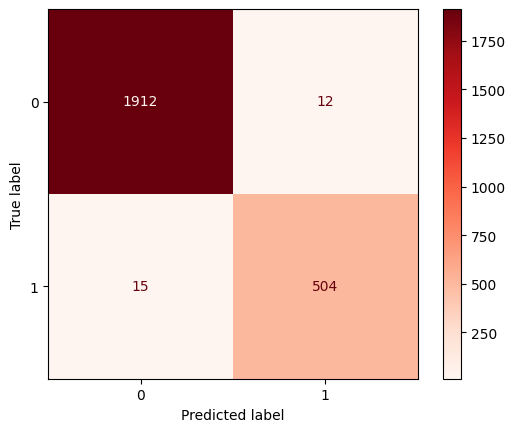

In [42]:
ConfusionMatrixDisplay.from_estimator(dt_param_search, X_test_processed, y_test, cmap = 'Reds')

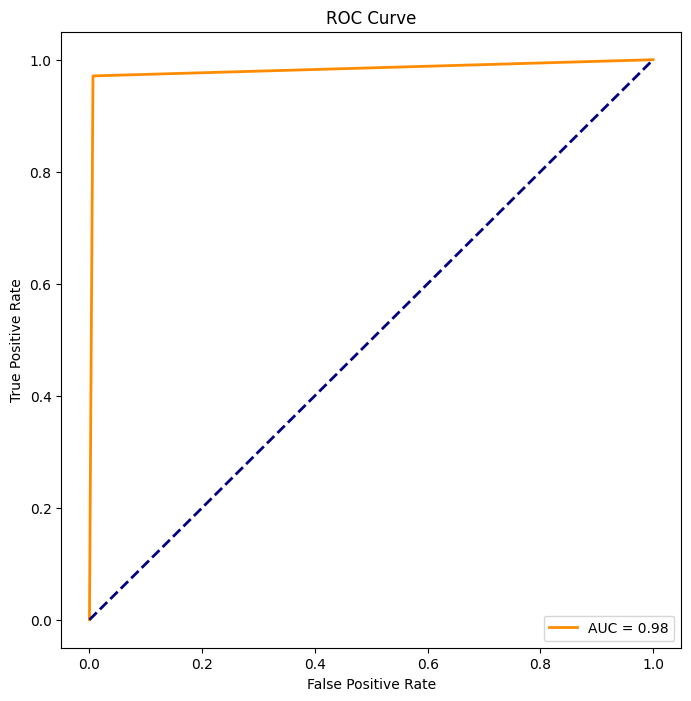

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds_dt)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Random Forest Report

In [44]:
rf_train_score = rf_param_search.score(X_train_processed, y_train)
rf_test_score = rf_param_search.score(X_test_processed, y_test)

print(rf_train_score)
print(rf_test_score)

1.0
0.9934506753990995


In [45]:
y_preds_rf = rf_param_search.predict(X_test_processed)
rf_clreport = classification_report(y_test, y_preds_rf)
print(rf_clreport)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1924
           1       0.99      0.98      0.98       519

    accuracy                           0.99      2443
   macro avg       0.99      0.99      0.99      2443
weighted avg       0.99      0.99      0.99      2443



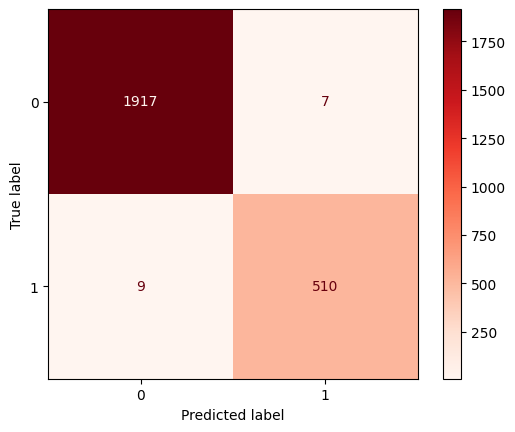

In [46]:
ConfusionMatrixDisplay.from_estimator(rf_param_search, X_test_processed, y_test, cmap = 'Reds')

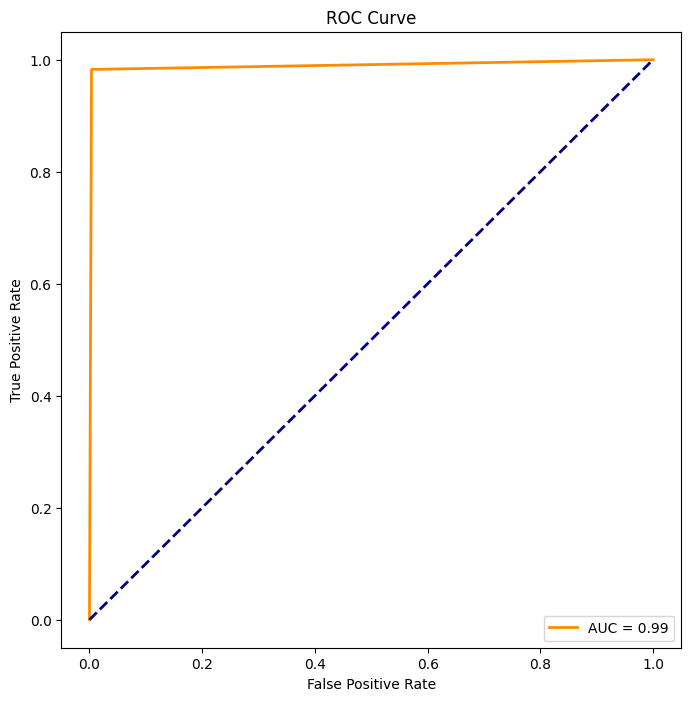

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds_rf)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Conclusion

RandomForestClassifier(bootstrap=False, max_depth=17, min_samples_split=5, n_estimators=303)

Our Decision Tree model achieved an optimal accuracy of 0.98894, with a precision of 99% and 98% for negative and positive cases respectively. Our model resulted in 12 false positives and 15 false negatives. Its AUC score is also considerable with 0.98.

Our Random Forest model achieved an accuracy of 0.995087 with only 7 false positives and 8 false negatives, thus optimizing our results. Our best AUC is 0.99.

If we need the maximum score regardless of the computational cost, I recommend using the Random Forest model. If we need a good trade-off between cost and results, the best model is the Decision Tree Classifier.

In [ ]:
rf = RandomForestClassifier(bootstrap=False, max_depth=93, min_samples_split=5, n_estimators=208)

flt_sel = make_column_selector(dtype_include='float')
cat_sel = make_column_selector(dtype_include='object')

imputer_float = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = make_column_transformer((make_pipeline(imputer_float, scaler),flt_sel),
                                      (make_pipeline(imputer_cat, ohe), cat_sel),
                                      remainder='passthrough')

pipe = make_pipeline(preprocessor,rf)
pipe